# Fair-Classification with AIF360 Introduction
The repo contains some functions for fairness in classification from https://github.com/mbilalzafar/fair-classification and several other methods for fairness in machine learning meant to be used with the AIF360 framework https://developer.ibm.com/open/projects/ai-fairness-360/.

The initial goal was to provide some methods for fairness in machine learning and a common data structure to use. Due to the availability of AIF360 the initial progress was discarded and some of the methods included into the AIF360 structure.

Available methods and functions are:

- disparate impact and disparate mistreatment remover
- preferential fairness 
- a function to plot decision boundaries on AIF360 data sets
- a synthetic data set
- methods for fairness warnings

In [1]:
import sys
import numpy as np
sys.path.append("../")

from aif360.datasets import GermanDataset
from aif360.metrics import ClassificationMetric
from fairensics.data.synthetic_dataset import SyntheticDataset
from fairensics.data.decision_boundary import DecisionBoundary 
from fairensics.methods import FairDisparateImpact, AccurateDisparateImpact
from fairensics.methods import DisparateMistreatment
from fairensics.methods import PreferentialFairness
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 0. Short Example:

## 0.1 Load Data

In [2]:
# load a data set (either one from AIF360 or a 2D data set from fair-classification)
syn_data = SyntheticDataset()

# splitting the data into train and test set
syn_train, syn_test = syn_data.split([0.7], shuffle=True)

## 0.2 Train Models

In [3]:
# logistic regression without constraints (for comparison)
logreg = FairDisparateImpact()
logreg.fit(syn_train)

# logistic regression with constraints 
dspim = FairDisparateImpact()
dspim.fit(syn_train)

../fairensics/methods/fairness_warnings.py:203: UserWarning: Ratio  between label and attribute  for protected attribute: protected_attribute is  above threshold of 0.4
  warnings.warn(warning_msg)


## 0.3 Make Predictions

In [4]:
logreg_predictions = logreg.predict(syn_test)
dispim_predictions = dspim.predict(syn_test)

## 0.4 Evaluation

In [5]:
# print some metrics using AIF
privileged_groups = [{'protected_attribute': 1}]
unprivileged_groups = [{'protected_attribute': 0}]

dspim_metric = ClassificationMetric(syn_test, 
                                    dispim_predictions, 
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)

logreg_metric = ClassificationMetric(syn_test, 
                                     logreg_predictions, 
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

print("unconstrained logistic regression accuracy: \t", logreg_metric.accuracy())
print("constrained logistic regression accuracy: \t", dspim_metric.accuracy())
print()

print("unconstrained logistic regression p-rule: \t", logreg_metric.disparate_impact())
print("constrained logistic regression p-rule: \t", dspim_metric.disparate_impact())

unconstrained logistic regression accuracy: 	 0.865
constrained logistic regression accuracy: 	 0.865

unconstrained logistic regression p-rule: 	 0.4669811320754717
constrained logistic regression p-rule: 	 0.4669811320754717


# 1. Full example

## 1.1 Load Data

The 2D synthetic data from fair-classification as AIF360 BinaryLabelDataset:

Synthetic data set features: 	 	 ['feature_1', 'feature_2', 'protected_attribute']
Synthetic data set protected attributes: ['protected_attribute']
Synthetic data set privileged classes: 	 [[1]]
Synthetic data set favorable label: 	 1.0
Synthetic data set shape: 	 	 (2000, 3)


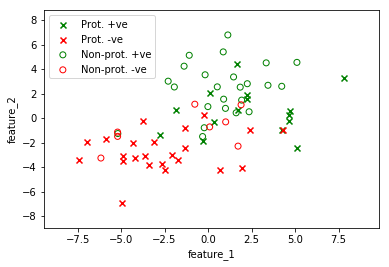

In [6]:
# The data set is an AIF360 StandardDataset annotated with protected columns, privileged classes and labels 

syn = SyntheticDataset()
print("Synthetic data set features: \t \t",syn.feature_names)
print("Synthetic data set protected attributes:", syn.protected_attribute_names)
print("Synthetic data set privileged classes: \t", syn.privileged_protected_attributes)
print("Synthetic data set favorable label: \t", syn.favorable_label)
print("Synthetic data set shape: \t \t", syn.features.shape)

# We added a plot function to visualize the points and a decision boundary plot, to compare
# the resulting decision boundary for different methods.
syn.plot(num_to_draw=70)


Green points belong to the positive class (e.g. being granted a credit) and red points correspondingly belong to the negative class.
A circle denotes, that the point does not belong to a protected group (e.g. the person is not a foreign worker) while a cross indicates membership in the protected group (e.g. the person is a foreign worker).

## 1.2 Computing Metrics
 The first method removes disparate impact. Formally, disparate impact is satisfied when the acceptance rate between protected and unprotected groups is equal. For example, 30 people apply for a job, but only 12 shall be hired.  Some of them are local and some are foreign workers. To satisfy disparate impact the same number of local and foreign workers must be hired (six of each). 

A relaxation of disparate impact is the p-rule, stating that the proportion in the acceptance rate between protected and unprotected groups must only be above some fraction p. 

For the above example and a p value of 0.6, it is fine to hire five foreigners and seven locals (because 5/7 = 0.71 > p = 0.6). 

Usually, p is chosen to be 80% (LINK?).    

First, the p-rule is computed on the raw data.

In [7]:
# computing the p-rule by hand
positive_label = syn.labels == 1

privileged_group = syn.protected_attributes == 1
unprivileged_group = syn.protected_attributes == 0

positive_label_privileged_group = positive_label == privileged_group
positive_label_unprivileged_group = positive_label == unprivileged_group

# print("p-rule: ", np.sum(positive_label_positive_class)/np.sum(positive_label_negative_class) )
print("p-rule: ", np.sum(positive_label_unprivileged_group)/np.sum(positive_label_privileged_group) )


p-rule:  0.47058823529411764


In [8]:
# using AIF to compute the p-rule
privileged_groups = [{'protected_attribute': 1}]
unprivileged_groups = [{'protected_attribute': 0}]

metric = ClassificationMetric(syn, 
                              syn, 
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("p-rule on raw data: \t", metric.disparate_impact())


p-rule on raw data: 	 0.4790144110402635


## 1. 3 Removing Disparate Impact
First, assure the unconstrained disparate impact remover has similar results as sklearn.

In [9]:
# split the data into train and test set
syn_train, syn_test = syn.split([0.7], shuffle=True)

In [10]:
# logistic regressio from sklearn
skclf = LogisticRegression()

# Only the first two columns of the data set are passed to sklearn (the unprotected attributes) 
# the disparate impact remover doesn’t consider them either for decision making
skclf.fit(syn_train.features[:, :2], syn_train.labels.ravel())

print("Sklearn logistic regression: ", skclf.score(syn_test.features[:, :2], syn_test.labels))

Sklearn logistic regression:  0.865


In [11]:
# disparate impact remover
dspim = FairDisparateImpact(warn=False)

# features and labels are annotated in the data set
dspim.fit(syn_train)

# there is no score function in AIF360, the evaluation is done using another class later 

### 1.3.1 Assuring that the learned weights are (roughly) the same:  

In [12]:
print(np.hstack((skclf.intercept_[:,None], skclf.coef_)).ravel())
print(dspim._params['w'])

[0.05261605 0.40838038 0.82711225]
[0.05359594 0.40896408 0.82963877]


It is also possible to verify this with decision boundary plots. The plotting function takes the features of the data set and a classifier to draw the boundary using a mesh grid. This way, nonlinear decision boundaries can be drawn. 

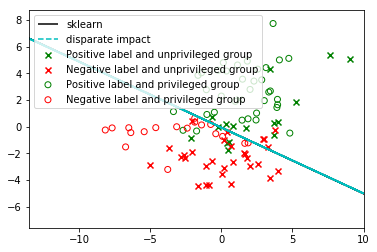

In [13]:
dec_bound = DecisionBoundary()
dec_bound.add_boundary(syn_test, skclf, label="sklearn", num_points=1000) # add one boundary
dec_bound.add_boundary(syn_test, dspim, label="disparate impact", num_points=1000) # add second boundary
dec_bound.scatter(syn_test) # add points to the plot
dec_bound.show()

Only one line is visible, hence the decision boundaries are identical.  

## 1.3.2 Training Constrained Classifier

In [14]:
# computing the p-rule on the unconstrained classifier   

predictions = dspim.predict(syn_test)
metric = ClassificationMetric(syn_test, 
                              predictions, 
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("p-rule on unconstrained classifier: \t", metric.disparate_impact())
print("accuracy on constrained classifier: \t", metric.accuracy())

p-rule on unconstrained classifier: 	 0.4669811320754717
accuracy on constrained classifier: 	 0.865


In [15]:
# optimize accuracy subject to fainess constraints
dspim_f = FairDisparateImpact(warn=False)
dspim_f.fit(syn_train)

In [16]:
predictions = dspim_f.predict(syn_test)

metric = ClassificationMetric(syn_test, 
                              predictions, 
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("p-rule on constrained classifier: \t", metric.disparate_impact())
print("accuracy on constrained classifier: \t", metric.accuracy())

p-rule on constrained classifier: 	 0.4669811320754717
accuracy on constrained classifier: 	 0.865


The results are almost the same.

In [17]:
# optimize fairness subject to accuracy constraints
dspim_a = AccurateDisparateImpact(warn=False)
dspim_a.fit(syn_train)

In [18]:
predictions = dspim_a.predict(syn_test)
metric = ClassificationMetric(syn_test, 
                              predictions, 
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("p-rule on constrained classifier: \t", metric.disparate_impact())
print("accuracy on constrained classifier: \t", metric.accuracy())

p-rule on constrained classifier: 	 1.20809406617446
accuracy on constrained classifier: 	 0.6866666666666666



The accuracy constraint produces the same results as the unconstrained one.
This can be visualized through the decision boundaries:

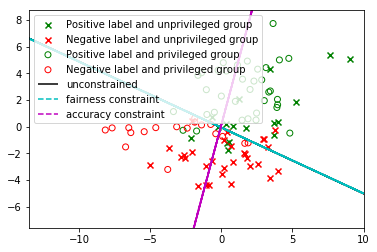

In [19]:
dec_bound = DecisionBoundary()
dec_bound.scatter(syn_test)
dec_bound.add_boundary(syn_test, skclf, label="unconstrained", num_points=1000)
dec_bound.add_boundary(syn_test, dspim_f, label="fairness constraint", num_points=1000)
dec_bound.add_boundary(syn_test, dspim_a, label="accuracy constraint", num_points=1000)
dec_bound.show()

## 1.4 Other Parameters
Other possible constraints and parameters are described in the corresponding notebooks starting with 2_...

# 2. Real World Data Set
The german credit data set (https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) is frequently used in fairness applications. It contains several features and a few of them can be considered protected.

In [20]:
# load the german credit data set 
gcd = GermanDataset()

Print some stats about the data set:

In [21]:
gcd.protected_attribute_names

['sex', 'age']

In [22]:
gcd.privileged_protected_attributes

[array([1.]), array([1.])]

In [23]:
gcd.unprivileged_protected_attributes

[array([0.]), array([0.])]

In [24]:
gcd.features.shape

(1000, 58)

In [25]:
# split the data 
gcd_train, gcd_test = gcd.split([0.7], shuffle=True)

In [26]:
# protected and unprotected groups for the metric
unprivileged_groups = [{gcd.protected_attribute_names[0]:gcd.unprivileged_protected_attributes[0]}]
privileged_groups = [{gcd.protected_attribute_names[0]:gcd.privileged_protected_attributes[0]}]

print(unprivileged_groups)
print(privileged_groups)

[{'sex': array([0.])}]
[{'sex': array([1.])}]


In [27]:
# fairness constraint
dspim_f = FairDisparateImpact(warn=False)
dspim_f.fit(gcd_train)

predictions = dspim_f.predict(gcd_test)
gcd_metric = ClassificationMetric(gcd_test, 
                                  predictions, 
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

print("p-rule: \t", gcd_metric.disparate_impact())
print('accuracy: \t', gcd_metric.accuracy())

p-rule: 	 0.7749612350839344
accuracy: 	 0.7633333333333333


../fairensics/methods/disparate_impact.py:364: UserWarning: Only the first protected attribute is considered with this constraint.
  warnings.warn("Only the first protected attribute is considered with this constraint.")


In [28]:
# accuracy constraint
dspim_a = AccurateDisparateImpact(warn=False)
dspim_a.fit(gcd_train)

predictions = dspim_a.predict(gcd_test)
gcd_metric = ClassificationMetric(gcd_test, 
                                  predictions, 
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

print("p-rule: \t", gcd_metric.disparate_impact())
print('accuracy: \t', gcd_metric.accuracy())

p-rule: 	 0.9215167548500881
accuracy: 	 0.74


In [29]:
# sklearn

from fairensics.fairensics_utils import get_unprotected_attributes

skclf = LogisticRegression()

skclf.fit(get_unprotected_attributes(gcd_train), gcd_train.labels.ravel())
skclf.score(get_unprotected_attributes(gcd_test), gcd_test.labels)

0.76

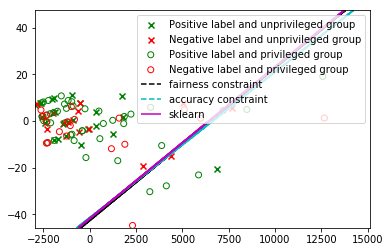

In [30]:
# decision boundaries
dec_bound = DecisionBoundary()
dec_bound.scatter(gcd_test)
dec_bound.add_boundary(gcd_test, dspim_f, label="fairness constraint", num_points=1000)
dec_bound.add_boundary(gcd_test, dspim_a, label="accuracy constraint", num_points=1000)
dec_bound.add_boundary(gcd_test, skclf, label="sklearn", num_points=1000)
dec_bound.show()